## Base Models

In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from imblearn.over_sampling import SMOTE

def load_and_preprocess_mfcc(classCSVPath):
    """Loads and preprocesses MFCC data."""
    mfcc_df = pd.read_csv(classCSVPath)
    label_encoder = LabelEncoder()
    mfcc_df["Label"] = label_encoder.fit_transform(mfcc_df["Label"])

    mfcc_features = mfcc_df.iloc[:, 3:].values
    labels = mfcc_df["Label"].values

    scaler = StandardScaler()
    mfcc_features = scaler.fit_transform(mfcc_features)
    mfcc_features = mfcc_features.reshape(mfcc_features.shape[0], mfcc_features.shape[1], 1)

    labels_one_hot = to_categorical(labels)

    return mfcc_features, labels_one_hot, label_encoder


def load_and_preprocess_spectrogram(spectrogram_paths, label_encoder):
    """Loads and preprocesses spectrogram data."""

    def _load_spectrogram_image(path):  # Inner helper function
        BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), "../"))
        corrected_path = os.path.abspath(os.path.join(BASE_DIR, path))
        if os.path.exists(corrected_path):
            img = load_img(corrected_path, target_size=(224, 224), color_mode='rgb')
            img = img_to_array(img) / 255.0
            return img, os.path.basename(os.path.dirname(corrected_path))
        else:
            print(f"Warning: Spectrogram not found at {corrected_path}")
            return None, None  # Or raise an exception if you prefer

    images = []
    labels = []
    for path in spectrogram_paths:
        img, label = _load_spectrogram_image(path)
        if img is not None:  # Check if image was loaded successfully
            images.append(img)
            labels.append(label)

    images = np.array(images)
    labels = label_encoder.transform(labels) # Use the same LabelEncoder
    labels_one_hot = to_categorical(labels)
    return images, labels_one_hot


def apply_augmentation_and_smote(X_train_spectrogram, y_train_spectrogram):
    """Applies data augmentation and SMOTE to spectrogram data."""
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    datagen.fit(X_train_spectrogram)  # Fit BEFORE SMOTE

    smote = SMOTE(random_state=37)
    X_train_reshaped = X_train_spectrogram.reshape(X_train_spectrogram.shape[0], -1) # Reshape for SMOTE
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train_reshaped, np.argmax(y_train_spectrogram, axis=1))
    X_train_resampled = X_train_resampled.reshape(-1, 224, 224, 3) # Reshape back
    y_train_resampled = to_categorical(y_train_resampled)

    return X_train_resampled, y_train_resampled, datagen


def apply_smote_mfcc(X_train_mfcc, y_train_mfcc):
    """Applies SMOTE to MFCC data."""
    smote = SMOTE(random_state=37)
    X_train_reshaped = X_train_mfcc.reshape(X_train_mfcc.shape[0], -1) # Reshape for SMOTE
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train_reshaped, np.argmax(y_train_mfcc, axis=1))
    X_train_resampled = X_train_resampled.reshape(X_train_resampled.shape[0], X_train_resampled.shape[1], 1)
    y_train_resampled = to_categorical(y_train_resampled)
    return X_train_resampled, y_train_resampled



def SplitDataset(classCSVPath):
    """Main function to split and preprocess the dataset."""

    mfcc_features, y_mfcc, label_encoder = load_and_preprocess_mfcc(classCSVPath)
    spectrogram_paths = pd.read_csv(classCSVPath)["Spectrogram_Path"].values

    X_train_mfcc, X_test_mfcc, y_train_mfcc, y_test_mfcc, train_indices, test_indices = train_test_split(
        mfcc_features, y_mfcc, range(len(y_mfcc)), test_size=0.3, random_state=37, stratify = np.argmax(y_mfcc, axis=1) # Stratify based on original labels
    )

    X_train_spectrogram_paths = spectrogram_paths[train_indices]
    X_test_spectrogram_paths = spectrogram_paths[test_indices]

    X_train_spectrogram, y_train_spectrogram = load_and_preprocess_spectrogram(X_train_spectrogram_paths, label_encoder)
    X_test_spectrogram, y_test_spectrogram = load_and_preprocess_spectrogram(X_test_spectrogram_paths, label_encoder)


    X_train_spectrogram_resampled, y_train_spectrogram_resampled, datagen = apply_augmentation_and_smote(X_train_spectrogram, y_train_spectrogram)
    X_train_mfcc_resampled, y_train_mfcc_resampled = apply_smote_mfcc(X_train_mfcc, y_train_mfcc)

    return X_train_mfcc_resampled, y_train_mfcc_resampled, X_test_mfcc, y_test_mfcc, \
           X_train_spectrogram_resampled, y_train_spectrogram_resampled, X_test_spectrogram, y_test_spectrogram, \
           label_encoder, datagen


In [2]:
base_audio_path = r"C:\Users\gpish\Documents\GitHub\Incremental_Frameworks_Heart_Murmur_Classification\Dataset\base_audio_mfcc_features_with_labels.csv"

X_train_mfcc, y_train_mfcc, X_test_mfcc, y_test_mfcc, X_train_spec, y_train_spec, X_test_spec, y_test_spec, label_encoder, datagen = SplitDataset(base_audio_path)

# Now you have access to datagen:
# Example usage:
# model.fit(datagen.flow(X_train_spec, y_train_spec, batch_size=32), ...) # Example

In [3]:
# Print sample output
print(f"Sample MFCC Features Shape: {X_test_mfcc.shape}")  # (samples, timesteps, features)
print(f"Sample Spectrogram Image Shape: {X_test_spec.shape}")  # (samples, 224, 224, 3)
print(f"Sample Label One-Hot: {y_test_mfcc[12]}")  # Example label
print(f"Sample Label One-Hot: {y_test_spec[12]}")  # Example label

Sample MFCC Features Shape: (144, 13, 1)
Sample Spectrogram Image Shape: (144, 224, 224, 3)
Sample Label One-Hot: [1. 0. 0. 0.]
Sample Label One-Hot: [1. 0. 0. 0.]


In [4]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
# Evaluation and Visualization
def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    plt.tight_layout()
    plt.show()

def evaluate_model(model, X_test, y_test, label_encoder, dataset_name):
    y_pred_probs = model.predict(X_test)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y_test, axis=1)
    print("Test Accuracy: ", accuracy_score(y_true, y_pred))
    print(f"Classification Report ({dataset_name}):")
    print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix ({dataset_name})')
    plt.show()

## MFCC Models

### CNN Model

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, BatchNormalization, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

In [7]:
cnn_model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', kernel_regularizer=l2(0.001), input_shape=(X_train_mfcc.shape[1], 1)),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    Conv1D(128, kernel_size=3, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    Flatten(),
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),

    Dense(y_train_mfcc.shape[1], activation='softmax')  # Output layer
])

cnn_model.summary()

C:\Users\gpish\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 11, 64)              │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 11, 64)              │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 5, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 3, 128)              │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 3, 128)              │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 1, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 34,244 (133.77 KB)

 Trainable params: 33,860 (132.27 KB)

 Non-trainable params: 384 (1.50 KB)

In [8]:
# Compile the model
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=False) # Adjust patience as needed

# Train the model
history = cnn_model.fit(X_train_mfcc, y_train_mfcc, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping]) # Adjust epochs and batch size


Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - accuracy: 0.4908 - loss: 1.6203 - val_accuracy: 0.7941 - val_loss: 1.4076
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8637 - loss: 0.6029 - val_accuracy: 0.8676 - val_loss: 1.3532
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9328 - loss: 0.4101 - val_accuracy: 0.8824 - val_loss: 1.3272
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9331 - loss: 0.4184 - val_accuracy: 0.9265 - val_loss: 1.2940
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9321 - loss: 0.3668 - val_accuracy: 0.9118 - val_loss: 1.2705
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9678 - loss: 0.3248 - val_accuracy: 0.8824 - val_loss: 1.2620
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9423 - loss: 0.3609 - val_accuracy: 0.8676 - val_loss: 1.2292
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9518 - loss: 0.3389 - val_accuracy: 0.8529 - val_loss: 1.1918
Epoch 

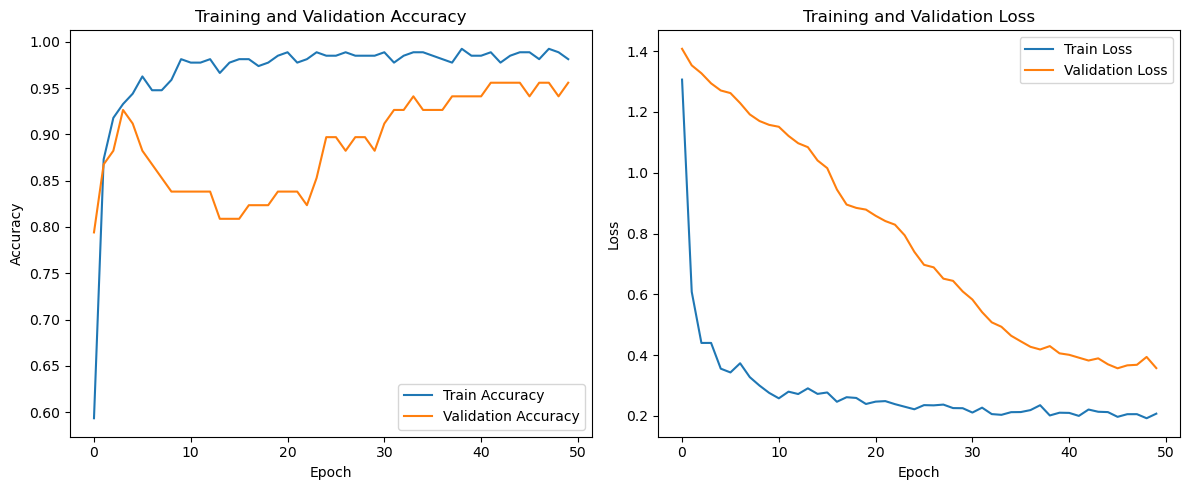

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Test Accuracy:  0.9861111111111112
Classification Report (Test Data):
              precision    recall  f1-score   support

          AS       1.00      1.00      1.00        36
          MR       0.97      1.00      0.99        36
          MS       1.00      0.94      0.97        36
           N       0.97      1.00      0.99        36

    accuracy                           0.99       144
   macro avg       0.99      0.99      0.99       144
weighted avg       0.99      0.99      0.99       144



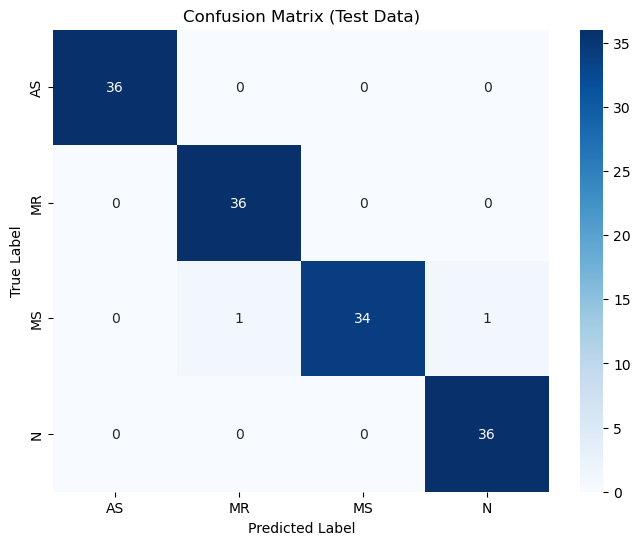

In [9]:
plot_training_history(history)

evaluate_model(cnn_model, X_test_mfcc, y_test_mfcc, label_encoder, "Test Data")

In [10]:
cnn_model.save('RedoneModels/mfcc_cnn.h5')

### LSTM

In [11]:
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [12]:
lstm_model = Sequential([
    LSTM(64, input_shape=(X_train_mfcc.shape[1], 1), return_sequences=True),
    LSTM(64),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(y_train_mfcc.shape[1], activation='softmax')  # Output layer with softmax activation
])
lstm_model.summary()

C:\Users\gpish\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 13, 64)              │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 54,340 (212.27 KB)

 Trainable params: 54,340 (212.27 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
lstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=False) 

history = lstm_model.fit(
    X_train_mfcc, y_train_mfcc, 
    epochs=50, 
    batch_size=32, 
    validation_split = 0.2,
    callbacks=[early_stopping,]
)

Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 92ms/step - accuracy: 0.4759 - loss: 1.3601 - val_accuracy: 0.7500 - val_loss: 1.2646
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6603 - loss: 1.2345 - val_accuracy: 0.8088 - val_loss: 1.0399
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6997 - loss: 1.0416 - val_accuracy: 0.8088 - val_loss: 0.7166
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7510 - loss: 0.7420 - val_accuracy: 0.8382 - val_loss: 0.5729
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8678 - loss: 0.5531 - val_accuracy: 0.8235 - val_loss: 0.5375
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8820 - loss: 0.4665 - val_accuracy: 0.8676 - val_loss: 0.4114
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8940 - loss: 0.3439 - val_accuracy: 0.8824 - val_loss: 0.3965
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9370 - loss: 0.3071 - val_accuracy: 0.9265 - val_loss: 0.3425


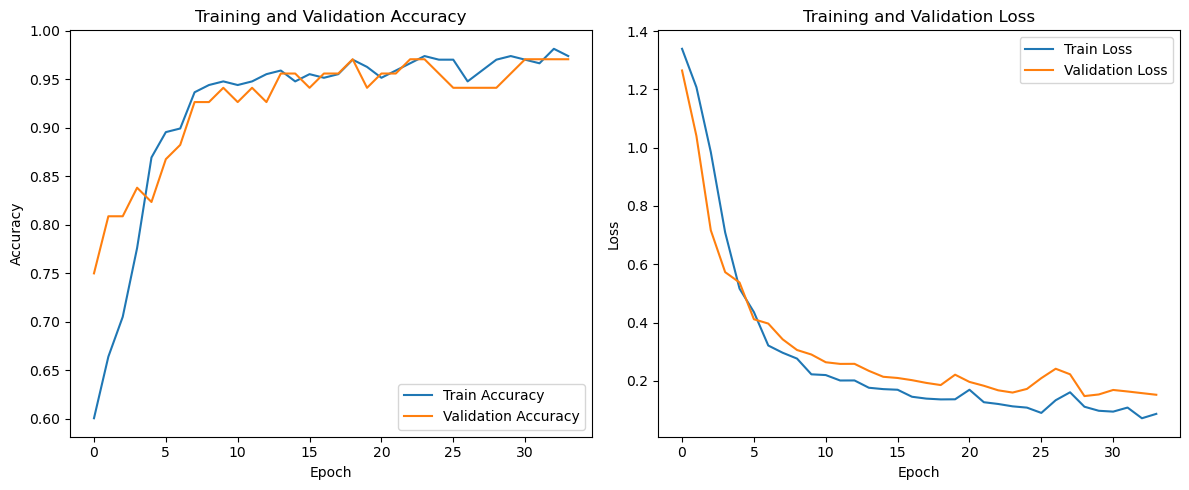

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step
Test Accuracy:  0.9791666666666666
Classification Report (Test Data):
              precision    recall  f1-score   support

          AS       0.97      1.00      0.99        36
          MR       0.95      1.00      0.97        36
          MS       1.00      0.92      0.96        36
           N       1.00      1.00      1.00        36

    accuracy                           0.98       144
   macro avg       0.98      0.98      0.98       144
weighted avg       0.98      0.98      0.98       144



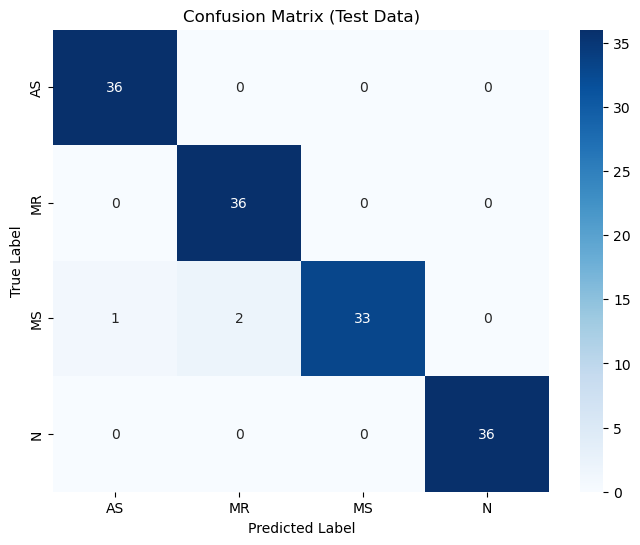

In [14]:
plot_training_history(history)

evaluate_model(lstm_model, X_test_mfcc, y_test_mfcc, label_encoder, "Test Data")

In [15]:
lstm_model.save("RedoneModels/mfcc_lstm.h5")

### BiLSTM

In [16]:
from tensorflow.keras.layers import Bidirectional

In [17]:
# BiLSTM Model
bilstm_model = Sequential([
    Bidirectional(LSTM(64, return_sequences=True), input_shape=(X_train_mfcc.shape[1], 1)),
    Bidirectional(LSTM(64)),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(y_train_mfcc.shape[1], activation='softmax')  # Output layer with softmax activation
])
bilstm_model.summary()

C:\Users\gpish\anaconda3\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)        │ (None, 13, 128)             │          33,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 128)                 │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 141,124 (551.27 KB)

 Trainable params: 141,124 (551.27 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
bilstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=False) 

history = bilstm_model.fit(
    X_train_mfcc, y_train_mfcc, 
    epochs=50, 
    batch_size=32, 
    validation_split = 0.2,
    callbacks=[early_stopping,]
)

Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 11s 141ms/step - accuracy: 0.3923 - loss: 1.3631 - val_accuracy: 0.6176 - val_loss: 1.2002
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6093 - loss: 1.1481 - val_accuracy: 0.5882 - val_loss: 0.8938
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6292 - loss: 0.8524 - val_accuracy: 0.6765 - val_loss: 0.7026
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7034 - loss: 0.6538 - val_accuracy: 0.8529 - val_loss: 0.5861
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8195 - loss: 0.5824 - val_accuracy: 0.8088 - val_loss: 0.5309
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8696 - loss: 0.4283 - val_accuracy: 0.8235 - val_loss: 0.4723
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8979 - loss: 0.3964 - val_accuracy: 0.9118 - val_loss: 0.3819
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9235 - loss: 0.3381 - val_accuracy: 0.9118 - val_loss: 0.329

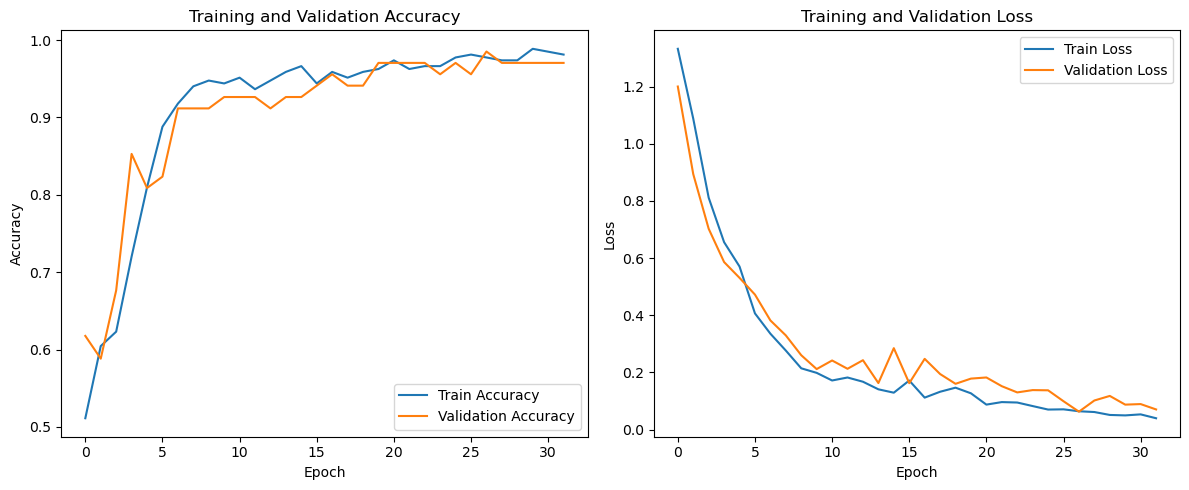

1/5 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/stepWARNING:tensorflow:5 out of the last 11 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x0000022D89007B00> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 235ms/step
Test Accuracy:  0.9861111111111112
Classification Report (Test Data):
              precision    recall  f1-score   support

          AS       0.97      1.00      0.99        36
          MR       0.97      1.00      0.99        36
          MS       1.00      0.94      0.97        36
           N       1.00      1.00      1.00        36

    accuracy                           0.99       144
   macro avg       0.99      0.99      0.99       144
weighted avg       0.99      0.99      0.99       144



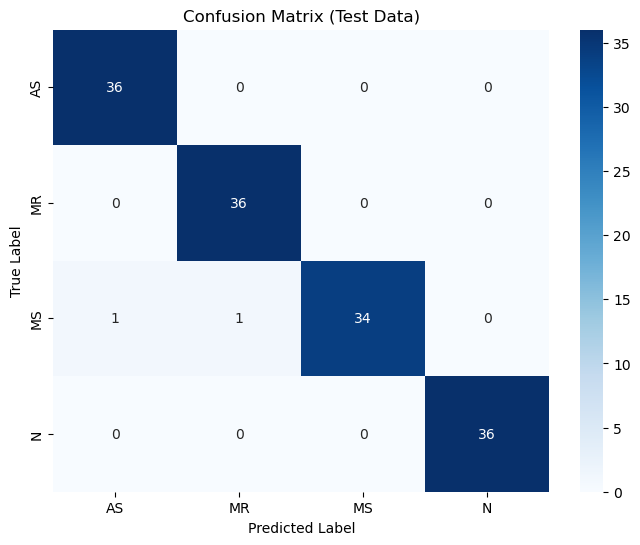

In [19]:
plot_training_history(history)

evaluate_model(bilstm_model, X_test_mfcc, y_test_mfcc, label_encoder, "Test Data")

In [20]:
bilstm_model.save("RedoneModels/mfcc_bilstm.h5")

## Spectrogram

In [21]:
import tensorflow as tf
X_train_np = np.array(X_train_spec)
y_train_np = np.array(y_train_spec)

# Calculate the number of samples for validation
num_val_samples = int(0.2 * len(X_train_np))

# Randomly shuffle the training data
indices = np.arange(len(X_train_np))
np.random.shuffle(indices)
X_train_np = X_train_np[indices]
y_train_np = y_train_np[indices]

# Split into training and validation sets
X_train_actual = X_train_np[num_val_samples:]
y_train_actual = y_train_np[num_val_samples:]
X_val = X_train_np[:num_val_samples]
y_val = y_train_np[:num_val_samples]

train_dataset = tf.data.Dataset.from_tensor_slices((X_train_actual, y_train_actual))
train_dataset = train_dataset.batch(32).repeat()

validation_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))  # Use test set as validation set
validation_dataset = validation_dataset.batch(32)

### MobileNet

In [22]:
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model

In [23]:
# MobileNetV2 Model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3)) # Load pre-trained MobileNetV2 (without the top classification layer)

# Freeze the base model's layers (optional, but often a good idea initially)
base_model.trainable = False

# Add custom classification head on top of MobileNetV2
x = base_model.output
x = GlobalAveragePooling2D()(x) # Global average pooling to reduce to 1D
x = Dense(1024, activation='relu', kernel_regularizer=l2(0.001))(x) # L2 regularization
x = Dropout(0.5)(x)
x = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(x) # L2 regularization
x = Dropout(0.5)(x)
predictions = Dense(y_train_spec.shape[1], activation='softmax')(x) # Output layer

# Create the final model
mobile_net_model = Model(inputs=base_model.input, outputs=predictions)

# mobile_net_model.summary()

In [24]:
mobile_net_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=False) 

history = mobile_net_model.fit(
    train_dataset,  # Use data augmentation
    epochs=30, 
    steps_per_epoch=len(X_train_spec) // 32, # Number of batches per epoch
    validation_data=validation_dataset, # Use test data for validation
    callbacks=[early_stopping]
)

Epoch 1/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 16s 627ms/step - accuracy: 0.4454 - loss: 3.0899 - val_accuracy: 0.9104 - val_loss: 1.8517
Epoch 2/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 327ms/step - accuracy: 0.8067 - loss: 1.9922 - val_accuracy: 0.9552 - val_loss: 1.4861
Epoch 3/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 358ms/step - accuracy: 0.8306 - loss: 1.6354 - val_accuracy: 0.9254 - val_loss: 1.4032
Epoch 4/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 332ms/step - accuracy: 0.8906 - loss: 1.4016 - val_accuracy: 1.0000 - val_loss: 1.1175
Epoch 5/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 357ms/step - accuracy: 0.9360 - loss: 1.2569 - val_accuracy: 0.9851 - val_loss: 1.0594
Epoch 6/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 338ms/step - accuracy: 0.9609 - loss: 1.0956 - val_accuracy: 0.9851 - val_loss: 1.0308
Epoch 7/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 355ms/step - accuracy: 0.9599 - loss: 1.0420 - val_accuracy: 1.0000 - val_loss: 0.9409
Epoch 8/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 400ms/step - accuracy: 0.9677 - loss: 0.9849 - val_accuracy: 1

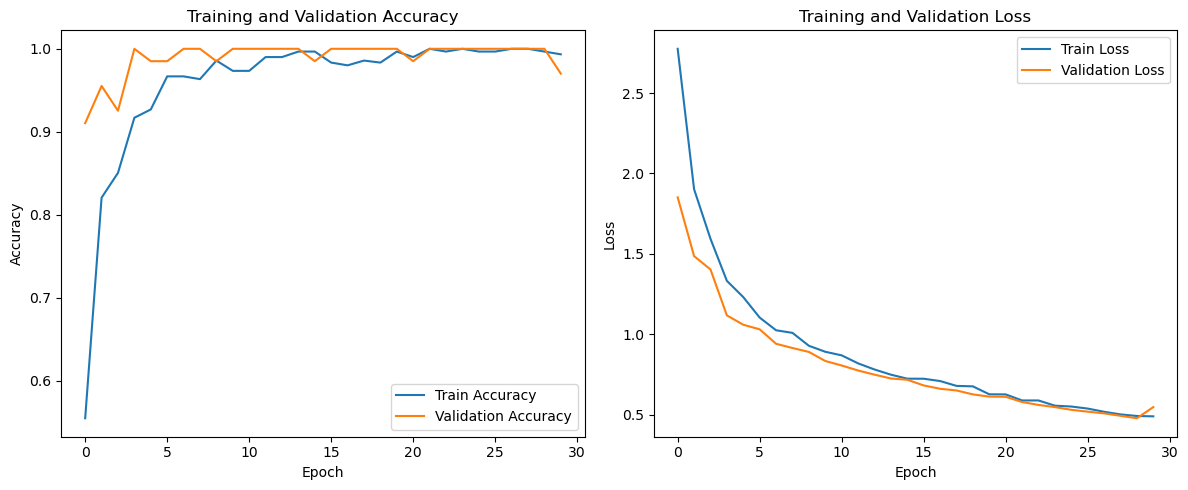

5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 641ms/step
Test Accuracy:  0.9791666666666666
Classification Report (Test Data):
              precision    recall  f1-score   support

          AS       0.97      1.00      0.99        36
          MR       1.00      0.92      0.96        36
          MS       0.95      1.00      0.97        36
           N       1.00      1.00      1.00        36

    accuracy                           0.98       144
   macro avg       0.98      0.98      0.98       144
weighted avg       0.98      0.98      0.98       144



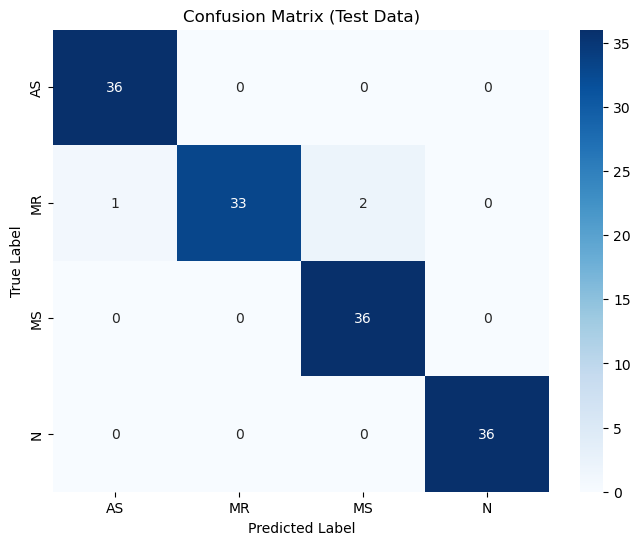

In [25]:
plot_training_history(history)

evaluate_model(mobile_net_model, X_test_spec, y_test_spec, label_encoder, "Test Data")

In [26]:
mobile_net_model.save("RedoneModels/spec_mbnet.h5")

### ResNet 

In [27]:
from tensorflow.keras.applications import ResNet50V2  # Import ResNet50V2

In [28]:
base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

# Add custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu', kernel_regularizer=l2(0.001))(x) # L2 regularization
x = Dropout(0.5)(x)
x = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(x) # L2 regularization
x = Dropout(0.5)(x)
predictions = Dense(y_train_spec.shape[1], activation='softmax')(x)

# Create the final model
resnet_model = Model(inputs=base_model.input, outputs=predictions)

# resnet_model.summary()

In [29]:
resnet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=False) 

history = resnet_model.fit(
    train_dataset,  # Use data augmentation
    epochs=30, 
    steps_per_epoch=len(X_train_spec) // 32, # Number of batches per epoch
    validation_data=validation_dataset, # Use test data for validation
    callbacks=[early_stopping]
)

Epoch 1/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.3635 - loss: 3.6376 - val_accuracy: 0.9104 - val_loss: 1.9847
Epoch 2/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.7664 - loss: 2.0779 - val_accuracy: 0.9254 - val_loss: 1.5018
Epoch 3/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.8276 - loss: 1.5592 - val_accuracy: 0.9254 - val_loss: 1.2547
Epoch 4/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.9277 - loss: 1.2506 - val_accuracy: 0.9403 - val_loss: 1.0900
Epoch 5/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.9250 - loss: 1.1159 - val_accuracy: 0.9403 - val_loss: 1.0004
Epoch 6/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.9254 - loss: 1.0091 - val_accuracy: 0.9701 - val_loss: 0.9067
Epoch 7/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.9708 - loss: 0.9034 - val_accuracy: 0.9701 - val_loss: 0.8504
Epoch 8/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.9665 - loss: 0.8742 - val_accuracy: 0.9552 - val_loss:

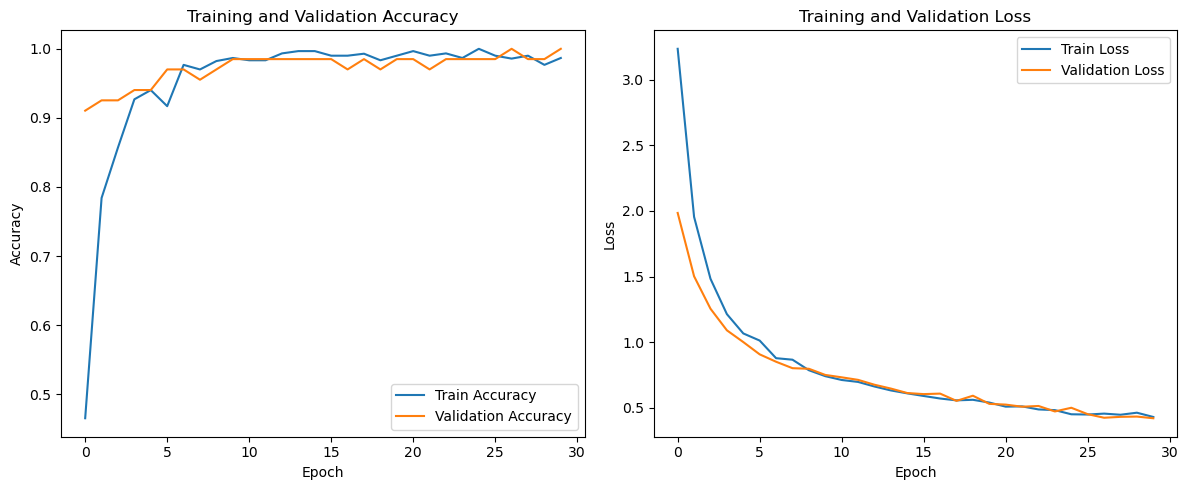

5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step
Test Accuracy:  0.9652777777777778
Classification Report (Test Data):
              precision    recall  f1-score   support

          AS       1.00      1.00      1.00        36
          MR       0.88      1.00      0.94        36
          MS       1.00      0.86      0.93        36
           N       1.00      1.00      1.00        36

    accuracy                           0.97       144
   macro avg       0.97      0.97      0.97       144
weighted avg       0.97      0.97      0.97       144



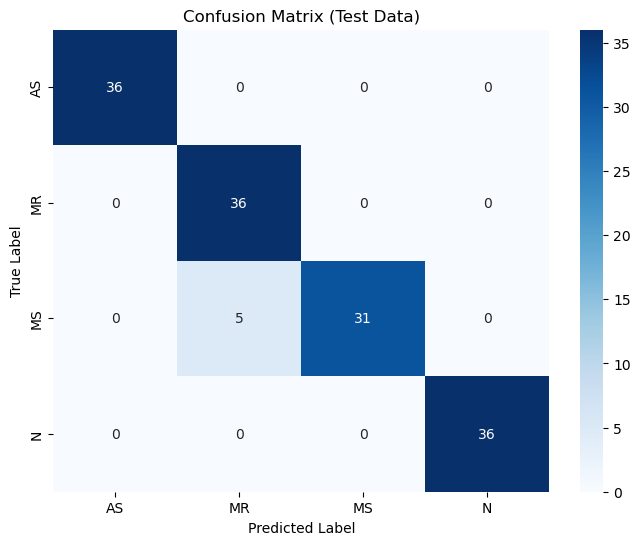

In [30]:
plot_training_history(history)

evaluate_model(resnet_model, X_test_spec, y_test_spec, label_encoder, "Test Data")

In [31]:
mobile_net_model.save("RedoneModels/spec_resnet.h5")

## Ensemble

In [32]:
import numpy as np

mfcc_bilstm_model = tf.keras.models.load_model("./RedoneModels/mfcc_bilstm.h5")
mfcc_cnn_model = tf.keras.models.load_model("./RedoneModels/mfcc_cnn.h5")
mfcc_lstm_model = tf.keras.models.load_model("./RedoneModels/mfcc_lstm.h5")

spectrogram_mobilenet_model = tf.keras.models.load_model("./RedoneModels/spec_mbnet.h5")
spectrogram_resnet_model = tf.keras.models.load_model("./RedoneModels/spec_resnet.h5")

# Get predictions from each model (probabilities)
mfcc_cnn_preds = mfcc_cnn_model.predict(X_test_mfcc)  # Assuming X_mfcc_test is your MFCC test data
mfcc_lstm_preds = mfcc_lstm_model.predict(X_test_mfcc)
mfcc_bilstm_preds = mfcc_bilstm_model.predict(X_test_mfcc)

spectrogram_mobilenet_preds = spectrogram_mobilenet_model.predict(X_test_spec)
spectrogram_resnet_preds = spectrogram_resnet_model.predict(X_test_spec)

# Define weights for each model (adjust these based on performance)
weights = {
    "mfcc_cnn": 0.2,
    "mfcc_lstm": 0.2,
    "mfcc_bilstm": 0.2,
    "spectrogram_mobilenet": 0.2,
    "spectrogram_resnet": 0.2,
}

# Calculate the weighted average of predictions
final_predictions = (
    weights["mfcc_cnn"] * mfcc_cnn_preds
    + weights["mfcc_lstm"] * mfcc_lstm_preds
    + weights["mfcc_bilstm"] * mfcc_bilstm_preds
    + weights["spectrogram_mobilenet"] * spectrogram_mobilenet_preds
    + weights["spectrogram_resnet"] * spectrogram_resnet_preds
)

# Get the predicted labels (class with highest probability)
final_labels = np.argmax(final_predictions, axis=1)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 224ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 728ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 864ms/step


Classification Report (Test Data):
              precision    recall  f1-score   support

          AS       1.00      1.00      1.00        36
          MR       1.00      1.00      1.00        36
          MS       1.00      1.00      1.00        36
           N       1.00      1.00      1.00        36

    accuracy                           1.00       144
   macro avg       1.00      1.00      1.00       144
weighted avg       1.00      1.00      1.00       144



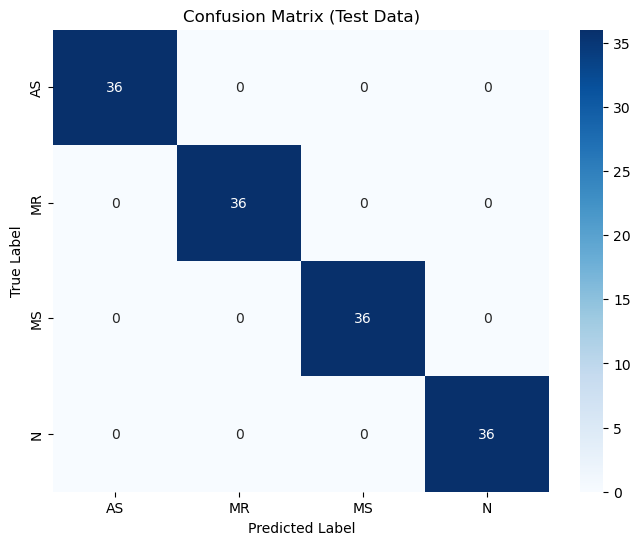

In [33]:
def evaluate_final_predictions(final_predictions, y_test, label_encoder, dataset_name="Test Data"):
    """Evaluates the final predictions (after ensemble averaging)."""

    y_pred = np.argmax(final_predictions, axis=1)  # Get predicted labels
    y_true = np.argmax(y_test, axis=1) # If y_test is one-hot encoded

    print(f"Classification Report ({dataset_name}):")
    print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix ({dataset_name})')
    plt.show()

    return y_true, y_pred # Return true and predicted labels if needed


# ... (Your model training, prediction, and ensemble averaging code)

# Evaluate the final predictions
y_true_final, y_pred_final = evaluate_final_predictions(final_predictions, y_test_mfcc, label_encoder)

## Incremental

In [34]:
import tensorflow as tf
import numpy as np

class EWC:
    def __init__(self, model, previous_weights, fisher_matrix, lambda_ewc=100.0):
        self.model = model
        self.previous_weights = previous_weights
        self.fisher_matrix = fisher_matrix
        self.lambda_ewc = lambda_ewc

    def ewc_loss(self):
        if self.previous_weights is None or self.fisher_matrix is None:
            return 0.0

        loss = 0.0
        for layer in self.model.layers:
            if layer.name in self.previous_weights and layer.name in self.fisher_matrix:
                if isinstance(layer, tf.keras.layers.Conv2D):
                    delta_w = tf.cast(layer.kernel, tf.float32) - tf.cast(self.previous_weights[layer.name], tf.float32)  # Cast to float32
                    fisher = tf.cast(self.fisher_matrix[layer.name], tf.float32) # Cast to float32
                    loss += self.lambda_ewc * tf.reduce_sum(fisher * delta_w**2)
                elif len(layer.get_weights()) > 0:
                    delta_w = tf.cast(layer.get_weights()[0], tf.float32) - tf.cast(self.previous_weights[layer.name], tf.float32)  # Cast to float32
                    fisher = tf.cast(self.fisher_matrix[layer.name], tf.float32) # Cast to float32
                    loss += self.lambda_ewc * tf.reduce_sum(fisher * delta_w**2)
        return loss

    def compute_fisher(self, X, y):
        num_samples = X.shape[0]
        fisher_matrix = {}

        for layer in self.model.layers:
            if len(layer.get_weights()) > 0:
                if isinstance(layer, tf.keras.layers.Conv2D):
                    fisher_matrix[layer.name] = np.zeros(layer.kernel.shape)
                else:
                    fisher_matrix[layer.name] = np.zeros(layer.get_weights()[0].shape)

        for i in range(num_samples):
            with tf.GradientTape() as tape:
                # Watch the kernel weights directly, converted to Tensors
                watched_vars = []
                for layer in self.model.layers:
                    if isinstance(layer, tf.keras.layers.Conv2D):
                        watched_vars.append(tf.convert_to_tensor(layer.kernel))
                    elif len(layer.get_weights()) > 0:
                        watched_vars.append(tf.convert_to_tensor(layer.get_weights()[0]))
                tape.watch(watched_vars)

                predictions = self.model(np.expand_dims(X[i], axis=0))
                loss = tf.keras.losses.CategoricalCrossentropy()(np.expand_dims(y[i], axis=0), predictions)

            gradients = tape.gradient(loss, watched_vars)

            k = 0
            for layer in self.model.layers:
                if layer.name in fisher_matrix and len(layer.get_weights()) > 0:
                    if gradients[k] is not None:  # Check for None gradients!
                        if isinstance(layer, tf.keras.layers.Conv2D):
                            fisher_matrix[layer.name] += np.square(gradients[k].numpy())
                        else:
                            fisher_matrix[layer.name] += np.square(gradients[k].numpy())
                    k += 1  # Increment k even if gradient is None (to keep indices aligned)

        for layer in self.model.layers:
            if layer.name in fisher_matrix and len(layer.get_weights()) > 0:
                fisher_matrix[layer.name] /= num_samples
        return fisher_matrix

In [35]:
mfcc_bilstm_model = tf.keras.models.load_model("./RedoneModels/mfcc_bilstm.h5")
mfcc_cnn_model = tf.keras.models.load_model("./RedoneModels/mfcc_cnn.h5")
mfcc_lstm_model = tf.keras.models.load_model("./RedoneModels/mfcc_lstm.h5")

spectrogram_mobilenet_model = tf.keras.models.load_model("./RedoneModels/spec_mbnet.h5")
spectrogram_resnet_model = tf.keras.models.load_model("./RedoneModels/spec_resnet.h5")

models = {"mfcc_bilstm":mfcc_bilstm_model, "mfcc_lstm":mfcc_lstm_model, "mfcc_cnn":mfcc_cnn_model, 
          "spectrogram_mobilenet":spectrogram_mobilenet_model, "spectrogram_resnet":spectrogram_resnet_model}

In [36]:
inc_audio_path = "C:/Users/gpish/Documents/GitHub/Incremental_Frameworks_Heart_Murmur_Classification/Dataset/inc_audio_mfcc_features_with_labels.csv"
new_X_train_mfcc, new_y_train_mfcc, new_X_test_mfcc, new_y_test_mfcc, new_X_train_spec, new_y_train_spec, new_X_test_spec, new_y_test_spec, new_label_encoder, new_datagen = SplitDataset(inc_audio_path)

In [37]:
ewc_objects = {}  # Store EWC objects for each model

for model_name, model in models.items():  # Assuming you have a dictionary of models
    if model_name in ["spectrogram_mobilenet", "spectrogram_resnet"]:
        X_train_task1 = X_train_spec
        y_train_task1 = y_train_spec
    else:
        X_train_task1 = X_train_mfcc
        y_train_task1 = y_train_mfcc

    fisher_matrix = EWC(model, None, None).compute_fisher(X_train_task1, y_train_task1)
    previous_weights = {}

    for layer in model.layers:
        if hasattr(layer, 'get_weights') and len(layer.get_weights()) > 0: # Check if layer has weights
            if isinstance(layer, tf.keras.layers.Conv2D):
                previous_weights[layer.name] = layer.kernel.numpy().astype(np.float32).copy()
            else:
                weights = layer.get_weights()
                if isinstance(weights, list) and len(weights) > 0:  # Check if weights is a list and not empty
                    previous_weights[layer.name] = weights[0].astype(np.float32).copy()

    ewc_objects[model_name] = EWC(model, previous_weights, fisher_matrix)
    print("Completed Task 1 for Model ", model_name)

Completed Task 1 for Model  mfcc_bilstm
Completed Task 1 for Model  mfcc_lstm
Completed Task 1 for Model  mfcc_cnn
Completed Task 1 for Model  spectrogram_mobilenet
Completed Task 1 for Model  spectrogram_resnet


In [38]:
# --- Task 2 (Incremental Learning) ---
# ... (Load or prepare your new data for Task 2: X_train_task2, y_train_task2, X_test_task2, y_test_task2)

for model_name, model in models.items():
    ewc = ewc_objects[model_name]
    optimizer = tf.keras.optimizers.Adam()

    if model_name in ["spectrogram_mobilenet", "spectrogram_resnet"]:
        X_train_task2 = new_X_train_spec  # Use NEW data
        y_train_task2 = new_y_train_spec
        X_test_task2 = new_X_test_spec
        y_test_task2 = new_y_test_spec
    else:
        X_train_task2 = new_X_train_mfcc  # Use NEW data
        y_train_task2 = new_y_train_mfcc
        X_test_task2 = new_X_test_mfcc
        y_test_task2 = new_y_test_mfcc

    for epoch in range(10):  # Adjust number of epochs
        with tf.GradientTape() as tape:
            predictions = model(X_train_task2)
            loss = tf.keras.losses.CategoricalCrossentropy()(y_train_task2, predictions)
            loss += ewc.ewc_loss()
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    # Evaluate on the new task
    loss, accuracy = model.evaluate(X_test_task2, y_test_task2, verbose=0)
    print(f"Model: {model_name}, Task 2 Loss: {loss:.4f}, Accuracy: {accuracy:.4f}")

    save_path = f"C:/Users/gpish/Documents/GitHub/Incremental_Frameworks_Heart_Murmur_Classification/Code/IncrementalUpdatedModels/{model_name}_updated.h5"
    os.makedirs(os.path.dirname(save_path), exist_ok=True) # Create directory if needed
    model.save(save_path)

    # Update previous weights and Fisher matrix
    ewc.previous_weights = {}
    for layer in model.layers:
        if len(layer.get_weights()) > 0:
            if isinstance(layer, tf.keras.layers.Conv2D):
                ewc.previous_weights[layer.name] = layer.kernel.numpy().copy()
            else:
                ewc.previous_weights[layer.name] = layer.get_weights()[0].copy()

    # Compute the new fisher matrix on the new training data
    ewc.fisher_matrix = ewc.compute_fisher(X_train_task2, y_train_task2)

Model: mfcc_bilstm, Task 2 Loss: 0.3795, Accuracy: 0.9062


Model: mfcc_lstm, Task 2 Loss: 0.3815, Accuracy: 0.9167


Model: mfcc_cnn, Task 2 Loss: 0.3878, Accuracy: 0.8958



KeyboardInterrupt

